In [1]:
import numpy as np
import pandas as pd

In [2]:
import operator

from copy import copy

In [3]:
from sklearn.metrics import mean_squared_error

In [4]:
import matplotlib.pyplot as plt

%matplotlib inline

In [5]:
df = pd.read_csv("../data/train.txt", sep='\t', header=None, names=["users", "items", "rank"])
df.head()

,users,items,rank
0,1,1,5
1,1,2,3
2,1,3,4
3,1,4,3
4,1,5,3


In [6]:
df["rank"].unique()

array([5, 3, 4, 1, 2])

In [7]:
n_users = df["users"].max()
n_items = df["items"].max()

In [8]:
df[["users", "items"]] -= 1
df.head()

,users,items,rank
0,0,0,5
1,0,1,3
2,0,2,4
3,0,3,3
4,0,4,3


In [9]:
def score(matrix, values):
    y_pred = [matrix[user, item] for user, item, rank in values]
    y_true = map(operator.itemgetter(2), values)
    return mean_squared_error(y_true, y_pred)

In [10]:
def iter_step(weights, bias, df_grouped, C, alpha):
    weights_, bias_ = copy(weights), copy(bias)
    func = lambda x, alpha: np.diag(1.0 + alpha * r)
    func = lambda x, alpah: np.diag(1.0 + alpha * np.log(1.0 + r))
    
    for user, group in df_grouped["users"]:
        index = group["items"].values
        
        Q = weights_["items"][index]
        Q = np.hstack((np.ones(shape=(len(index), 1), dtype=float), Q))
        r = group["rank"].values - bias_["items"][index]
        G = np.diag(1.0 + alpha * r)
        
        A = np.dot(Q.T, np.dot(G, Q)) + C * np.eye(Q.shape[1])
        b = np.dot(Q.T, np.dot(G, r))
        
        solution = np.linalg.solve(A, b)
        weights_["users"][user], bias_["users"][user] = solution[1:], solution[0] 
    
    for item, group in df_grouped["items"]:
        index = group["users"].values
        
        P = weights_["users"][index]
        P = np.hstack((np.ones(shape=(len(index), 1), dtype=float), P))
        r = group["rank"].values - bias_["users"][index]
        G = np.diag(1.0 + alpha * r)
        
        A = np.dot(P.T, np.dot(G, P)) + C * np.eye(P.shape[1])
        b = np.dot(P.T, np.dot(G, r))
        
        solution = np.linalg.solve(A, b)
        weights_["items"][item], bias_["items"][item] = solution[1:], solution[0]
        
    return weights_, bias_

In [11]:
index = np.random.permutation(df.shape[0])
beta = int(0.8 * len(index))

df_train, df_valid = df.iloc[index[:beta]], df.iloc[index[beta:]]

In [12]:
df_grouped = {cat : df_train.groupby(by=cat) for cat in ["users", "items"]}

In [13]:
results = dict()

In [49]:
C = 5.0
n_features = 2
alpha = 0.17

In [50]:
weights = dict()
weights["users"] = np.random.normal(loc=0.0, scale=0.01, size=(n_users, n_features))
weights["items"] = np.random.normal(loc=0.0, scale=0.01, size=(n_items, n_features))

bias = dict()
bias["users"] = np.random.normal(loc=0.0, scale=0.01, size=(n_users, ))
bias["items"] = np.random.normal(loc=0.0, scale=0.01, size=(n_items, ))
    
scores = []
    
n_iters = 60

for i in range(n_iters):
    weigths, bias = iter_step(weights, bias, df_grouped, C, alpha)
            
    matrix = bias["users"].reshape(-1, 1) + bias["items"].reshape(1, -1) \
            + np.dot(weights["users"], weights["items"].T)
    scores.append(
        (score(matrix, df_train.values),
         score(matrix, df_valid.values))
    )
        
    print "\r{} of {} iters passed...".format(i + 1, n_iters),

60 of 60 iters passed...


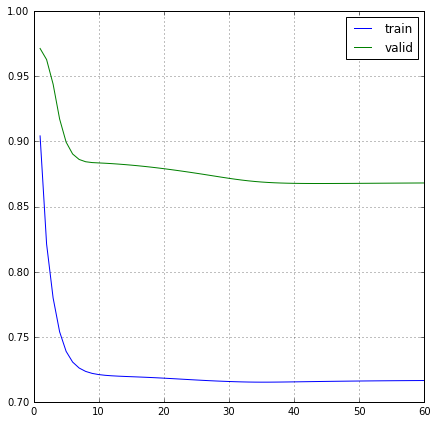

In [51]:
offset = 0

plt.figure(figsize=(7, 7))
plt.plot(range(offset+1, len(scores)+1), map(operator.itemgetter(0), scores)[offset:], label="train")
plt.plot(range(offset+1, len(scores)+1), map(operator.itemgetter(1), scores)[offset:], label="valid")
plt.legend()
plt.grid()

In [52]:
np.argsort(map(operator.itemgetter(1), scores))

array([43, 42, 44, 45, 41, 46, 40, 47, 48, 49, 39, 50, 51, 52, 38, 53, 54,
       55, 56, 57, 37, 58, 59, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26,
       25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10,  9,
        8,  7,  6,  5,  4,  3,  2,  1,  0])

In [53]:
np.min(map(operator.itemgetter(1), scores))

0.86765800159563067

In [54]:
a = map(operator.itemgetter(1), scores)
results[(C, n_features, alpha)] = (np.argmin(a), np.min(a))

In [55]:
results

{(5.0, 2, 0.12): (59, 0.87047418559981071),
 (5.0, 2, 0.13): (59, 0.86813928373130445),
 (5.0, 2, 0.14): (59, 0.86821602744669668),
 (5.0, 2, 0.15): (54, 0.86759204110077714),
 (5.0, 2, 0.16): (44, 0.86737137561840527),
 (5.0, 2, 0.17): (43, 0.86765800159563067)}